In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os

In [2]:
# load the datasets
try:
    x_train = pd.read_parquet('data/x_train.parquet')
    x_test = pd.read_parquet('data/x_test.parquet')
    y_train = pd.read_parquet('data/y_train.parquet')['y_train']
    y_test = pd.read_parquet('data/y_test.parquet')['y_test']
    print('Files successfully loaded!')
except FileNotFoundError:
    print('Files not found!')

Files successfully loaded!


In [3]:
# load the best model
if os.path.exists('models/XGBClassifier_best_model.pkl'):
    best_model = joblib.load('models/XGBClassifier_best_model.pkl')
    print('Best model successfully loaded!')
else:
    raise ValueError('Model not found!')

Best model successfully loaded!


In [4]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

In [5]:
# prediction model
from sklearn.calibration import CalibratedClassifierCV
calibrated_model = CalibratedClassifierCV(best_model,method='sigmoid',cv=cv)
calibrated_model.fit(x_train,y_train)

y_probs = calibrated_model.predict_proba(x_test)[:,1]
threshold = 0.25
y_pred = (y_probs >= threshold).astype(int)

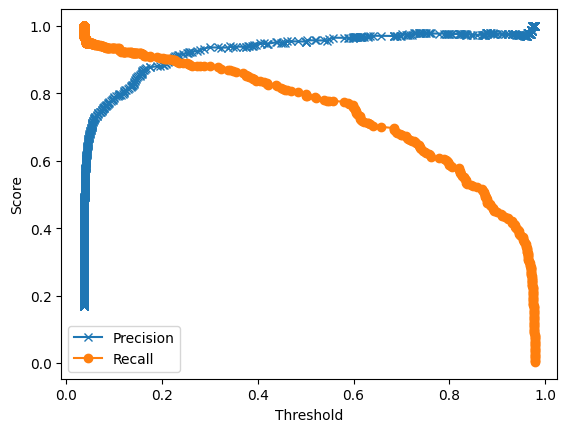

In [6]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

import matplotlib.pyplot as plt
plt.plot(thresholds, precisions[:-1], label="Precision",marker='x')
plt.plot(thresholds, recalls[:-1], label="Recall",marker='o')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.show()


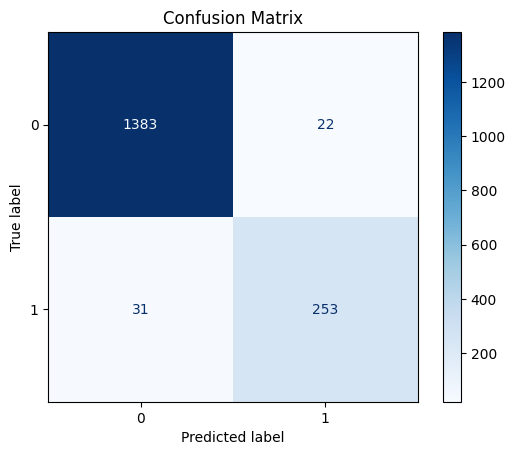

In [7]:
# confusion matrix - per-class misclassification
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(cm,display_labels=np.unique(y_test))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.savefig('plots/confusion_matrix.png',bbox_inches='tight',dpi=300)
plt.show()

In [8]:
from sklearn.metrics import precision_score,recall_score,classification_report

In [9]:
# precision - of all the positives that were predicted, how many where actual positives?
print(f'Precision Score : {round(precision_score(y_test,y_pred),2) * 100}%')

Precision Score : 92.0%


In [10]:
# recall - of all the actual positives, how many did we catch?
print(f'Recall Score : {round(recall_score(y_test,y_pred),2)*100}%')

Recall Score : 89.0%


In [11]:
# classification report - summary report of the model
print('Classification Report\n',classification_report(y_test,y_pred))

Classification Report
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1405
           1       0.92      0.89      0.91       284

    accuracy                           0.97      1689
   macro avg       0.95      0.94      0.94      1689
weighted avg       0.97      0.97      0.97      1689



In [12]:
from sklearn.model_selection import learning_curve,LearningCurveDisplay,cross_val_score

In [13]:
# cross validation scores across five folds - checks for model stability on train set
cv_score = cross_val_score(best_model,x_train,y_train,cv=5,scoring='accuracy')
print('CV Score on Training Set\n')
print('cv_accuracy_score across 5 folds : ',cv_score)
print('mean_cv_score : ',cv_score.mean())
print('std_cv_score : ',cv_score.std())

CV Score on Training Set

cv_accuracy_score across 5 folds :  [0.93282636 0.9428934  0.94416244 0.92385787 0.92385787]
mean_cv_score :  0.9335195872176436
std_cv_score :  0.008812682034577123


In [14]:
# checks for model stability on test set
cv_score = cross_val_score(best_model,x_test,y_pred,cv=5,scoring='accuracy')
print('CV Score on Test Set\n')
print('cv_accuracy_score across 5 folds : ',cv_score)
print('mean_cv_score : ',cv_score.mean())
print('std_cv_score : ',cv_score.std())

CV Score on Test Set

cv_accuracy_score across 5 folds :  [0.91715976 0.92011834 0.93195266 0.92899408 0.91691395]
mean_cv_score :  0.9230277597317086
std_cv_score :  0.00625344229247794


<Figure size 1000x700 with 0 Axes>

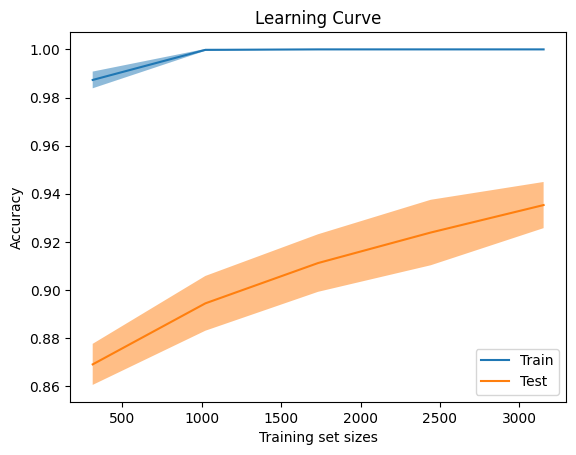

In [15]:
train_sizes, train_scores, test_scores = learning_curve(
    best_model,x_train,y_train,cv = 5, scoring='accuracy',shuffle=True,random_state=42,n_jobs= -1
)
plt.figure(figsize=(10,7))
disp = LearningCurveDisplay(
    train_sizes=train_sizes,
    train_scores=train_scores,
    test_scores=test_scores
)
disp.plot()
plt.title('Learning Curve')
plt.xlabel('Training set sizes')
plt.ylabel('Accuracy')
plt.show()

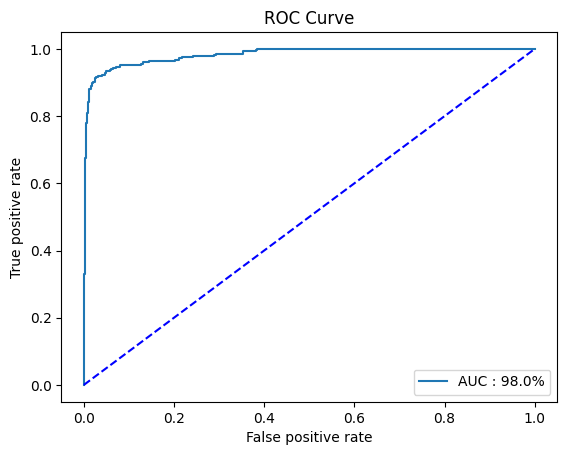

In [16]:
from sklearn.metrics import roc_auc_score,roc_curve
# the rate at which model classifiers model well - determines whether model is really learning or just randomly guessing
fpr,tpr,threshold = roc_curve(
    y_test,y_probs
)
auc_score = roc_auc_score(y_test,y_probs)
plt.plot(fpr,tpr,label=f'AUC : {round(auc_score,2)*100}%')
plt.plot([0,1],[0,1],linestyle='--',color='blue')
plt.title('ROC Curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()

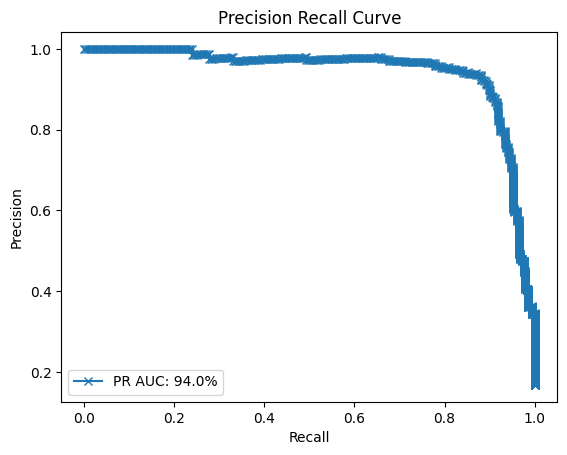

In [17]:
# precision recall tradeoff
from sklearn.metrics import precision_recall_curve,average_precision_score
precision,recall,threshold = precision_recall_curve (
    y_test,y_probs
)
pr_auc = average_precision_score(y_test,y_probs)
plt.plot(recall,precision,label=f'PR AUC: {round(pr_auc,2)*100}%',marker='x')
plt.title('Precision Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

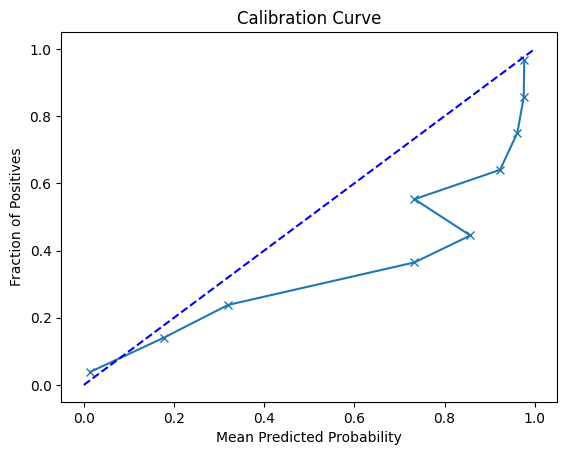

In [18]:
# compares how well predicted probabilties match real outcomes
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(
    y_test,y_probs, n_bins=10, strategy='uniform'
)
plt.plot(prob_true, prob_pred, marker= 'x')
plt.plot([0,1],[0,1],linestyle='--',color='blue')
plt.title('Calibration Curve')
plt.xlabel("Mean Predicted Probability")
plt.ylabel('Fraction of Positives')
plt.show()

In [19]:
from sklearn.metrics import brier_score_loss
print('Brier score loss : ',brier_score_loss(y_test,y_pred))

Brier score loss :  0.03137951450562463


In [20]:
from sklearn.metrics import log_loss
print('Log loss : ',log_loss(y_test,y_pred))

Log loss :  1.131032344359508


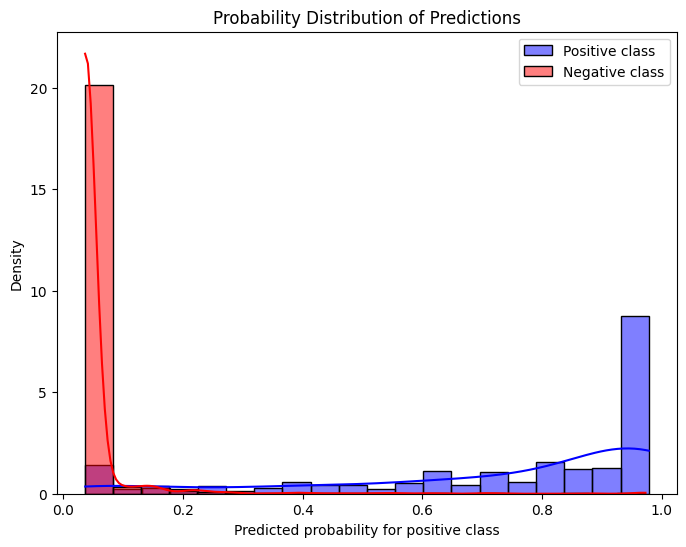

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Probabilities for positive class

plt.figure(figsize=(8,6))
sns.histplot(y_probs[y_test == 1], color="blue", label="Positive class", kde=True, stat="density", bins=20)
sns.histplot(y_probs[y_test == 0], color="red", label="Negative class", kde=True, stat="density", bins=20)

plt.xlabel("Predicted probability for positive class")
plt.ylabel("Density")
plt.title("Probability Distribution of Predictions")
plt.legend()
plt.show()


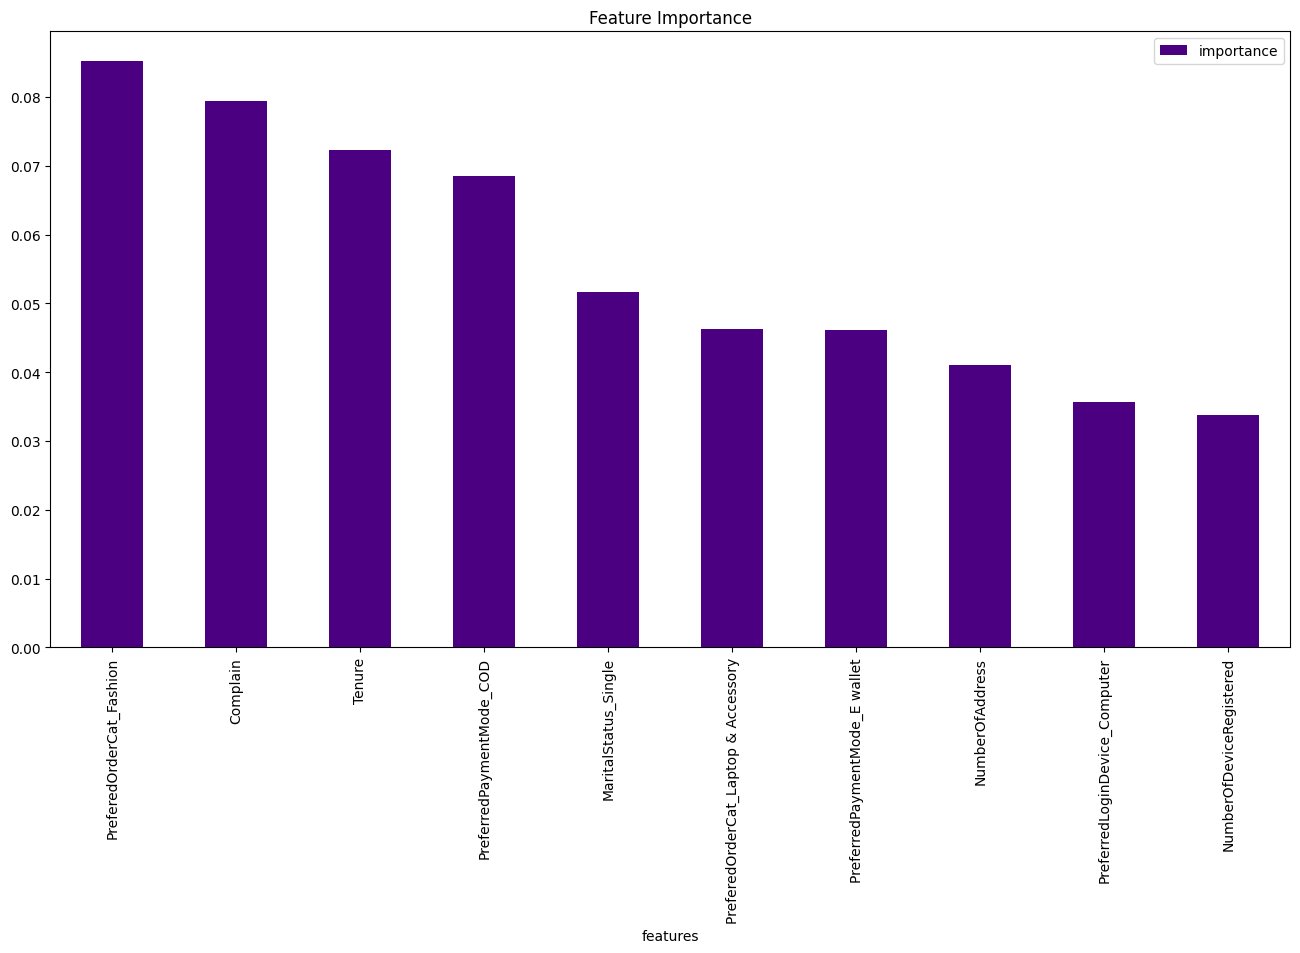

In [22]:
feature_names = best_model.named_steps.get('preprocessor',None).get_feature_names_out() # get feature names
importance = best_model.named_steps.get('classifier',None).feature_importances_ # get feature importance

feature_imp = pd.DataFrame({
    'features' : feature_names,
    'importance' : importance
}).sort_values(by='importance',ascending=False).head(10).plot.bar(x='features',y='importance',figsize=(16,8),color='indigo')
plt.title('Feature Importance')
plt.savefig('plots/feature_importance.png',bbox_inches='tight',dpi=300)
plt.show()

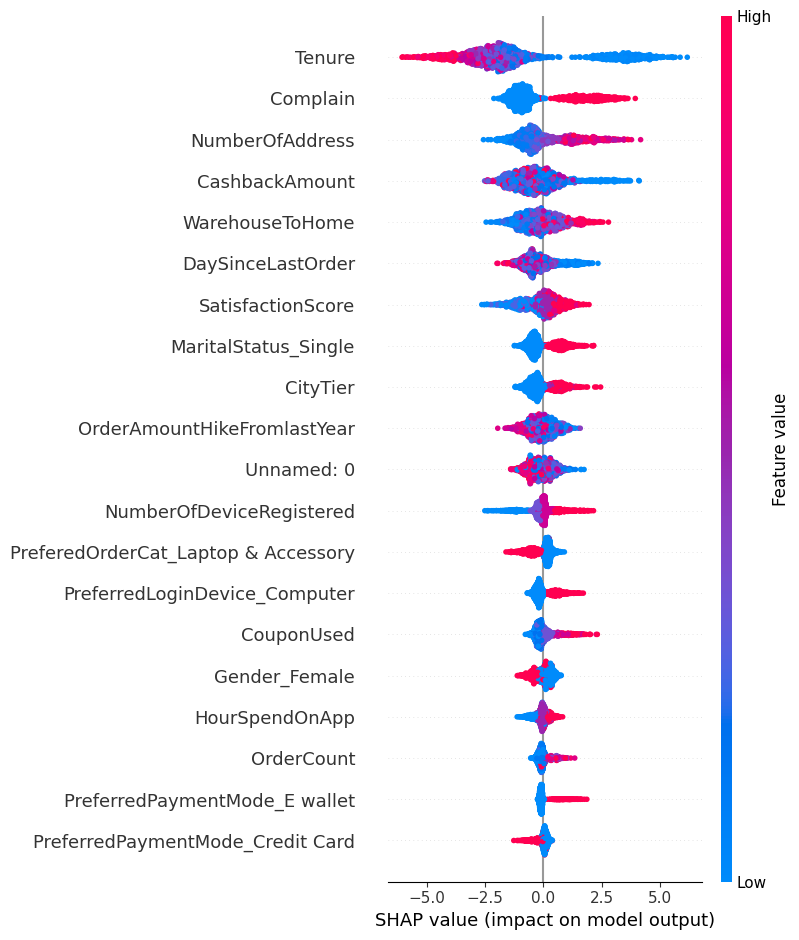

In [23]:
import shap
x_test_transformed = best_model.named_steps.get('preprocessor',None).transform(x_test)
explainer = shap.TreeExplainer(best_model.named_steps['classifier'])
shap_values = explainer(x_test_transformed)

plt.figure(figsize=(20,7))
shap.summary_plot(shap_values,x_test_transformed,feature_names=feature_names,show=False)
plt.savefig('plots/shap_summary.png',bbox_inches='tight',dpi=300)
plt.show()